In [1]:
import os
import numpy as np
import pandas as pd
import random
import copy

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from PIL import Image
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms import functional as F

import re
from collections import Counter
from transformers import (
    AutoConfig,
    AutoTokenizer, 
    AutoModel,
    AutoModelForSequenceClassification
)

from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
seed = 42
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [4]:
# Generator untuk DataLoader
g = torch.Generator()
g.manual_seed(seed)

def seed_worker(worker_id):
    """Fungsi untuk memastikan setiap worker memiliki seed yang sama"""
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [5]:
images_path = "/kaggle/input/situsjudiid-img4/situsjudiid"
train_csv_path = '/kaggle/input/situsjudiid-txt4-2/text/train_data.csv'
test_csv_path = '/kaggle/input/situsjudiid-txt4-2/text/test_data.csv'

In [6]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

test_df

,File Name,Extracted Text,Class
0,jasaasianwin88.shop_page3.png,4 Download APK | Mp LiveChat | HubungiKami | ...,judi
1,indojitu.hair_page5.png,(€ Info Terkini @ Cara Bermain le History No...,judi
2,jepe168win.com_page4.png,GITU TUS Enny: Ovosino2s a11s om |) | @) INDON...,judi
3,aidsagentjiliko.com_home.png,- Hide today c Wheel of Fortune # IVPJ Betti...,judi
4,langitkirin.org_home.png,ag AkiRinTOTo KIRINTOTO | LINK ALTERNATIF #KI...,judi
...,...,...,...
695,hondacengkareng.com.png,"Gratis Ongkir minimal belanja Rp. 100,000. Aku...",non-judi
696,tvcovers.com.au_page2.png,"(""DN Currency Login / Signup a P3Y kecut Ivco...",non-judi
697,campsite.bio_page6.png,campsite.bio Advanced analytics and insights ...,non-judi
698,furaffinity.net.png,19 Browse Upload Support 8 a Log In or Create ...,non-judi


In [7]:
# Drop missing values
print('Missing values in Train:\n', train_df.isna().sum())
train_df = train_df.dropna()

Missing values in Train:
 File Name           0
Extracted Text    132
Class               0
dtype: int64


In [8]:
def clean_texts(texts):
    temp_text = []
    all_words = []

    # Kata 1–2 huruf yang penting dan tidak boleh dihapus
    exceptions = {
        "di", "ke", "ya"
    }

    for text in texts:

        # ----- BASIC CLEANING -----
        text = re.sub(r"http\S+", "", text)  # Hapus URL
        text = re.sub(r"\n", " ", text)  # Ganti newline dengan spasi
        text = re.sub(r"[^a-zA-Z']", " ", text)  # Hanya sisakan huruf dan apostrof
        text = re.sub(r"\s{2,}", " ", text).strip().lower()  # Hapus spasi ganda, ubah ke lowercase

        # ----- FILTERING -----
        words = text.split()
        filtered_words = [
            w for w in words
            if (len(w) > 2 or w in exceptions)  # Simpan kata >2 huruf atau ada di exceptions
        ]
        text = ' '.join(filtered_words)

        # ----- REMOVE UNWANTED PATTERNS -----
        text = re.sub(r'\b[aeiou]+\b', '', text)  # Hapus kata semua vokal (panjang berapa pun)
        text = re.sub(r'\b[^aeiou\s]+\b', '', text)  # Hapus kata semua konsonan (panjang berapa pun)
        text = re.sub(r'\b\w{20,}\b', '', text)  # Hapus kata sangat panjang (≥20 huruf)
        text = re.sub(r'\s+', ' ', text).strip()  # Bersihkan spasi ekstra

        temp_text.append(text)  # Simpan teks yang sudah dibersihkan
        all_words.extend(text.split())  # Simpan semua kata dari semua teks untuk hitung frekuensi global

    # Hitung frekuensi kata
    word_counts = Counter(all_words)
    rare_words = {word for word, count in word_counts.items() if count == 1}  # Kata yang muncul 1x

    # Hapus kata yang jarang muncul
    final_texts = []
    for text in temp_text:
        words = text.split()
        cleaned_words = [word for word in words if word not in rare_words]
        final_texts.append(" ".join(cleaned_words))

    return final_texts

In [9]:
# Gabungkan teks dari train dan test sementara
combined_texts = pd.concat([train_df['Extracted Text'], test_df['Extracted Text']], ignore_index=True)

# Bersihkan semua teks gabungan
cleaned_all = clean_texts(combined_texts)

# Bagi kembali hasil cleaned text ke dalam train dan test
train_df['cleaned_text'] = cleaned_all[:len(train_df)]
test_df['cleaned_text'] = cleaned_all[len(train_df):]

In [10]:
# Drop rows with less than 5 words
train_df = train_df[train_df['cleaned_text'].apply(lambda x: len(str(x).split()) >= 5)]
test_df = test_df[test_df['cleaned_text'].apply(lambda x: len(str(x).split()) >= 5)]
train_df

,File Name,Extracted Text,Class,cleaned_text
0,0156726.slotslou.sbs.png,HOME jackpotpartycasinoslotsonline — login pr...,judi,home login bigwin jackpot codes
1,015eaglegaze.online.png,r #TOGrt AFATC Situs Online Gaming Terbaik Un...,judi,situs online gaming terbaik untuk gamers langs...
2,016-bar.pro.png,"""€! INFO TERKINI: (TOGEL ONLINE TERBESAR DAN T...",judi,info terkini togel online terbesar dan terpeca...
3,016-good.pro.png,Sa TIPE Nomor Ab sernncan 2 Sa HADIAHTOGEL —— ...,judi,tipe nomor mimpi imei referral hubungi kami
4,0164999.slotslou.sbs.png,bet 365 keluaran togel hongkong kemarin HOME ...,judi,bet keluaran togel hongkong kemarin home apk t...
...,...,...,...,...
7058,zoom.us.png,O cari Dukungan 1.888.799.9666 Minta Demo Berg...,non-judi,cari dukungan minta demo bergabung host masuk ...
7059,zoom.us_home.png,(O Cari Dukungan 1888.7990.9666 Minta Demo ZO...,non-judi,cari dukungan minta demo zoom rapat anda denga...
7060,zoom.us_page2.png,Dukungan 666 Minta Demo Bergabung stv Masuk ...,non-judi,dukungan minta demo bergabung masuk hubungi pe...
7061,zoom.us_page4.png,ZOOM z00m Work Transformation Summit APAC F...,non-judi,zoom work transformation summit from efficienc...


In [11]:
# Cek jumlah duplikasi sebelum dihapus
print("Duplikasi di train:", train_df.duplicated(subset='cleaned_text').sum())
print("Duplikasi di test :", test_df.duplicated(subset='cleaned_text').sum())

# Hapus duplikasi berdasarkan cleaned_text
train_df = train_df.drop_duplicates(subset='cleaned_text').reset_index(drop=True)
test_df = test_df.drop_duplicates(subset='cleaned_text').reset_index(drop=True)

# Cek ulang setelah pembersihan
print("Setelah dihapus:")
print("Train:", len(train_df), "baris")
print("Test :", len(test_df), "baris")

Duplikasi di train: 37
Duplikasi di test : 0
Setelah dihapus:
Train: 6541 baris
Test : 700 baris


In [12]:
# Print jumlah per kelas
print("Distribusi label di Train set:")
print(train_df['Class'].value_counts(), '\n')

print("Distribusi label di Test set:")
print(test_df['Class'].value_counts())

Distribusi label di Train set:
Class
non-judi    3969
judi        2572
Name: count, dtype: int64 

Distribusi label di Test set:
Class
judi        350
non-judi    350
Name: count, dtype: int64


In [13]:
from sklearn.utils import resample

# Pisahkan data berdasarkan kelas
train_judi = train_df[train_df['Class'] == 'judi']
train_nonjudi = train_df[train_df['Class'] == 'non-judi']

# Undersampling kelas mayoritas (non-judi) agar jumlahnya sama dengan kelas judi
train_nonjudi_undersampled = resample(train_nonjudi,
                                      replace=False,      # tanpa duplikasi
                                      n_samples=len(train_judi),  # samakan jumlahnya dengan kelas minoritas
                                      random_state=42)    # untuk replikasi hasil

# Gabungkan kembali data yang sudah diundersample
train_df_balanced = pd.concat([train_judi, train_nonjudi_undersampled])

# Cek distribusi baru
print("Distribusi label setelah undersampling:")
print(train_df_balanced['Class'].value_counts())

Distribusi label setelah undersampling:
Class
judi        2572
non-judi    2572
Name: count, dtype: int64


In [14]:
label_map = {
    "non-judi": 0,
    "judi": 1
}

train_df_balanced['label'] = train_df_balanced['Class'].map(label_map)
test_df['label'] = test_df['Class'].map(label_map)

train_df_balanced['image'] = train_df_balanced['File Name']
test_df['image'] = test_df['File Name']

In [15]:
traindf, validdf = train_test_split(
    train_df_balanced, test_size=0.2, stratify=train_df_balanced['label'], random_state=42
)

print(f"Jumlah data train: {len(traindf)}")
print(f"Jumlah data valid: {len(validdf)}")
print(f"Jumlah data test: {len(test_df)}")

Jumlah data train: 4115
Jumlah data valid: 1029
Jumlah data test: 700


In [16]:
# Print jumlah per kelas
print("Distribusi label di Train set:")
print(traindf['label'].value_counts(), '\n')

print("Distribusi label di Validation set:")
print(validdf['label'].value_counts(), '\n')

print("Distribusi label di Test set:")
print(test_df['label'].value_counts())

Distribusi label di Train set:
label
1    2058
0    2057
Name: count, dtype: int64 

Distribusi label di Validation set:
label
0    515
1    514
Name: count, dtype: int64 

Distribusi label di Test set:
label
1    350
0    350
Name: count, dtype: int64


In [17]:
class ResizePadToSquare:
    def __init__(self, target_size=300):
        self.target_size = target_size

    def __call__(self, img):
        img = img.convert("RGB")
        # Resize dengan thumbnail: jaga rasio, resize sisi terpanjang ke target
        img.thumbnail((self.target_size, self.target_size), Image.BILINEAR)
        # Padding agar menjadi square
        delta_w = self.target_size - img.size[0]
        delta_h = self.target_size - img.size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
        img = F.pad(img, padding, fill=0, padding_mode='constant')
        return img

In [18]:
transform_train = transforms.Compose([
    ResizePadToSquare(300),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    ResizePadToSquare(300),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [19]:
tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
max_length= 128

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [20]:
class CustomCombinedDataset(Dataset):
    def __init__(self, dataframe, images_path, tokenizer, max_length, transforms=None):
        self.dataframe = dataframe.reset_index(drop=True)  # Reset index to avoid KeyError
        self.images_path = images_path
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        img_name = os.path.join(self.images_path, row['image'])
        image = Image.open(img_name)
        label = row['label']

        text = str(row['cleaned_text'])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt',
            padding='max_length'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        if self.transforms is not None:
            image = self.transforms(image)

        return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [21]:
combined_train_dataset = CustomCombinedDataset(traindf, images_path, tokenizer, max_length, transforms=transform_train)
combined_valid_dataset = CustomCombinedDataset(validdf, images_path, tokenizer, max_length, transforms=transform_test)
combined_test_dataset = CustomCombinedDataset(test_df, images_path, tokenizer, max_length, transforms=transform_test)

In [22]:
batch_size = 16
combined_train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g)
combined_valid_loader = DataLoader(combined_valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g)
combined_test_loader = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g)

In [23]:
image_model_path = "/kaggle/input/gamblingiv1.14.2/pytorch/default/1/best_image_model_Adam_lr0.0001_bs32_state_dict.pt"
text_model_path = "/kaggle/input/gamblingtv1.14.2/pytorch/default/1/best_text_model_bs16_lr5e-05_ep3_state_dict.pt"

In [24]:
# # Inisialisasi ulang model
# image_model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
# num_features = image_model.classifier[1].in_features
# image_model.classifier = nn.Linear(num_features, 1)

# # Load state dict
# image_model.load_state_dict(torch.load(image_model_path, map_location=device))
# image_model.to(device)
# image_model.eval()

# # Inisialisasi ulang model
# text_model = AutoModelForSequenceClassification.from_pretrained(
#     'indobenchmark/indobert-base-p1',
#     num_labels=1
# )

# # Load state dict
# text_model.load_state_dict(torch.load(text_model_path, map_location=device))
# text_model.to(device)
# text_model.eval()

In [25]:
# Inisialisasi ulang model
image_model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
num_features = image_model.classifier[1].in_features
image_model.classifier = nn.Linear(num_features, 1)

# Load state dict
image_model.load_state_dict(torch.load(image_model_path, map_location=device))
image_model.to(device)
image_model.eval()

# Inisialisasi ulang model
text_model = AutoModelForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p1',
    num_labels=1
)

# Load state dict
text_model.load_state_dict(torch.load(text_model_path, map_location=device))
text_model.to(device)
text_model.eval()

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 201MB/s]
2025-05-17 13:40:39.508868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747489239.735675      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747489239.807067      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [26]:
# Define function to evaluate image model
def evaluate_image_model(model, data_loader):
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating Image Model"):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            outputs = model(images).squeeze(1)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    metrics = {
        'Accuracy': accuracy_score(all_labels, all_preds),
        'Precision': precision_score(all_labels, all_preds),
        'Recall': recall_score(all_labels, all_preds),
        'F1 Score': f1_score(all_labels, all_preds),
        'ConfusionMatrix': confusion_matrix(all_labels, all_preds)
    }
    return metrics

In [27]:
print("\n===== IMAGE MODEL EVALUATION =====")
image_metrics = evaluate_image_model(image_model, combined_test_loader)
print("\nTest Set Metrics:")
for metric_name, value in image_metrics.items():
    if metric_name != 'ConfusionMatrix':
        print(f"  {metric_name}: {value:.4f}")


===== IMAGE MODEL EVALUATION =====


Evaluating Image Model: 100%|██████████| 44/44 [00:16<00:00,  2.75it/s]


Test Set Metrics:
  Accuracy: 0.9786
  Precision: 0.9855
  Recall: 0.9714
  F1 Score: 0.9784


In [28]:
def evaluate_text_model(model, data_loader):
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating Text Model"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits.squeeze(1)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    return {
        'Accuracy': accuracy_score(all_labels, all_preds),
        'Precision': precision_score(all_labels, all_preds),
        'Recall': recall_score(all_labels, all_preds),
        'F1 Score': f1_score(all_labels, all_preds),
        'ConfusionMatrix': confusion_matrix(all_labels, all_preds)
    }

In [29]:
print("\n===== TEXT MODEL EVALUATION =====")
text_metrics = evaluate_text_model(text_model, combined_test_loader)
print("\nTest Set Metrics:")
for metric_name, value in text_metrics.items():
    if metric_name != 'ConfusionMatrix':
        print(f"  {metric_name}: {value:.4f}")


===== TEXT MODEL EVALUATION =====


Evaluating Text Model: 100%|██████████| 44/44 [00:12<00:00,  3.60it/s]


Test Set Metrics:
  Accuracy: 0.9943
  Precision: 0.9943
  Recall: 0.9943
  F1 Score: 0.9943


In [30]:
class LateFusionModel(nn.Module):
    def __init__(self, image_model, text_model):
        super(LateFusionModel, self).__init__()
        self.image_model = image_model
        self.text_model = text_model
        
        # Fusion weights - trainable parameters
        self.image_weight = nn.Parameter(torch.tensor(0.5))
        self.text_weight = nn.Parameter(torch.tensor(0.5))
        
    def forward(self, images, input_ids, attention_mask):
        # Get predictions from individual models
        with torch.no_grad():
            image_logits = self.image_model(images).squeeze(1)
            text_logits = self.text_model(input_ids=input_ids, attention_mask=attention_mask).logits.squeeze(1)
        
        # Normalize weights using softmax to ensure they sum to 1
        weights = torch.softmax(torch.stack([self.image_weight, self.text_weight]), dim=0)
        
        # Weighted fusion of predictions
        fused_logits = weights[0] * image_logits + weights[1] * text_logits
        
        return fused_logits, image_logits, text_logits, weights

In [31]:
# Initialize the fusion model
fusion_model = LateFusionModel(image_model, text_model)
fusion_model.to(device)

# Training parameters
optimizer = optim.Adam([fusion_model.image_weight, fusion_model.text_weight], lr=0.001)
criterion = nn.BCEWithLogitsLoss()
fusion_epochs = 10

In [32]:
best_loss = float('inf')
best_weights = None  # Simpan bobot terbaik

for epoch in range(fusion_epochs):
    fusion_model.train()
    total_loss = 0.0

    for batch_data in tqdm(combined_valid_loader, desc=f"Training Epoch {epoch+1}/{fusion_epochs}"):
        images = batch_data['image'].to(device)
        input_ids = batch_data['input_ids'].to(device)
        attention_mask = batch_data['attention_mask'].to(device)
        labels = batch_data['label'].float().to(device)

        optimizer.zero_grad()
        fused_logits, _, _, weights = fusion_model(images, input_ids, attention_mask)
        loss = criterion(fused_logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(combined_valid_loader)
    norm_weights = torch.softmax(torch.stack([fusion_model.image_weight, fusion_model.text_weight]), dim=0)

    print(f'Epoch [{epoch+1}/{fusion_epochs}], Loss: {avg_loss:.4f}, '
          f'Image Weight: {norm_weights[0].item():.4f}, Text Weight: {norm_weights[1].item():.4f}')

    if avg_loss < best_loss:
        best_loss = avg_loss
        best_weights = norm_weights.clone()
        torch.save(fusion_model, 'best_fusion_model.pt')
        # torch.save(fusion_model.state_dict(), 'best_fusion_model_state_dict.pt')
        print("Best Fusion Model saved.")


# After training, print best weights
print(f"Best Fusion Weights: Image = {best_weights[0].item():.4f}, Text = {best_weights[1].item():.4f}")

Training Epoch 1/10: 100%|██████████| 65/65 [00:26<00:00,  2.49it/s]


Epoch [1/10], Loss: 0.0586, Image Weight: 0.4849, Text Weight: 0.5151
Best Fusion Model saved.


Training Epoch 2/10: 100%|██████████| 65/65 [00:20<00:00,  3.21it/s]


Epoch [2/10], Loss: 0.0549, Image Weight: 0.4705, Text Weight: 0.5295
Best Fusion Model saved.


Training Epoch 3/10: 100%|██████████| 65/65 [00:20<00:00,  3.10it/s]


Epoch [3/10], Loss: 0.0525, Image Weight: 0.4583, Text Weight: 0.5417
Best Fusion Model saved.


Training Epoch 4/10: 100%|██████████| 65/65 [00:20<00:00,  3.13it/s]


Epoch [4/10], Loss: 0.0506, Image Weight: 0.4453, Text Weight: 0.5547
Best Fusion Model saved.


Training Epoch 5/10: 100%|██████████| 65/65 [00:20<00:00,  3.15it/s]


Epoch [5/10], Loss: 0.0582, Image Weight: 0.4318, Text Weight: 0.5682


Training Epoch 6/10: 100%|██████████| 65/65 [00:20<00:00,  3.17it/s]


Epoch [6/10], Loss: 0.0552, Image Weight: 0.4163, Text Weight: 0.5837


Training Epoch 7/10: 100%|██████████| 65/65 [00:20<00:00,  3.21it/s]


Epoch [7/10], Loss: 0.0579, Image Weight: 0.4067, Text Weight: 0.5933


Training Epoch 8/10: 100%|██████████| 65/65 [00:20<00:00,  3.16it/s]


Epoch [8/10], Loss: 0.0429, Image Weight: 0.3984, Text Weight: 0.6016
Best Fusion Model saved.


Training Epoch 9/10: 100%|██████████| 65/65 [00:20<00:00,  3.15it/s]


Epoch [9/10], Loss: 0.0508, Image Weight: 0.3925, Text Weight: 0.6075


Training Epoch 10/10: 100%|██████████| 65/65 [00:20<00:00,  3.22it/s]

Epoch [10/10], Loss: 0.0559, Image Weight: 0.3831, Text Weight: 0.6169
Best Fusion Weights: Image = 0.3984, Text = 0.6016


In [33]:
# Load the best fusion model
fusion_model = torch.load('best_fusion_model.pt')
fusion_model.to(device)
# fusion_model.eval()

# # Inisialisasi ulang model dengan arsitektur yang sama
# fusion_model = LateFusionModel(image_model, text_model)  # image_model dan text_model harus sudah didefinisikan sebelumnya
# fusion_model.load_state_dict(torch.load('best_fusion_model_state_dict.pt'))
# fusion_model.to(device);

LateFusionModel(
  (image_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
            

In [34]:
def evaluate_fusion_model(fusion_model, data_loader):
    fusion_model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        weights = torch.softmax(torch.stack([fusion_model.image_weight, fusion_model.text_weight]), dim=0)
        print(f"Fusion Weights -> Image: {weights[0]:.4f}, Text: {weights[1]:.4f}")
        
        for batch in tqdm(data_loader, desc="Evaluating Fusion Model"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            fused_logits, _, _, _ = fusion_model(images, input_ids, attention_mask)
            fused_probs = torch.sigmoid(fused_logits).cpu().numpy()
            fused_preds = (fused_probs > 0.5).astype(int)
            
            all_preds.extend(fused_preds)
            all_labels.extend(labels.cpu().numpy())

    return {
        'Accuracy': accuracy_score(all_labels, all_preds),
        'Precision': precision_score(all_labels, all_preds),
        'Recall': recall_score(all_labels, all_preds),
        'F1 Score': f1_score(all_labels, all_preds),
        'AUC': roc_auc_score(all_labels, all_preds),
        'ConfusionMatrix': confusion_matrix(all_labels, all_preds)
    }

In [35]:
print("\n===== FUSION MODEL EVALUATION =====")
fusion_metrics = evaluate_fusion_model(fusion_model, combined_test_loader)
print("\nTest Set Metrics:")
for metric_name, value in fusion_metrics.items():
    if metric_name != 'ConfusionMatrix':
        print(f"  {metric_name}: {value:.4f}")


===== FUSION MODEL EVALUATION =====
Fusion Weights -> Image: 0.3984, Text: 0.6016


Evaluating Fusion Model: 100%|██████████| 44/44 [00:13<00:00,  3.18it/s]


Test Set Metrics:
  Accuracy: 0.9971
  Precision: 0.9971
  Recall: 0.9971
  F1 Score: 0.9971
  AUC: 0.9971


In [36]:
# Tampilkan semua confusion matrix
def plot_confusion_matrices(cm_dict):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    titles = ["Fusion Model", "Image Model", "Text Model"]
    
    for ax, (model_name, cm), title in zip(axes, cm_dict.items(), titles):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'Confusion Matrix: {title}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    
    plt.tight_layout()
    plt.show()

# Dictionary dengan CM semua model
conf_matrices = {
    'fusion': fusion_metrics['ConfusionMatrix'],
    'image': image_metrics['ConfusionMatrix'],
    'text': text_metrics['ConfusionMatrix']
}

In [37]:
# Create a DataFrame to easily compare all models
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Fusion Model': [fusion_metrics['Accuracy'], fusion_metrics['Precision'], 
                    fusion_metrics['Recall'], fusion_metrics['F1 Score']],
    'Image Model': [image_metrics['Accuracy'], image_metrics['Precision'], 
                   image_metrics['Recall'], image_metrics['F1 Score']],
    'Text Model': [text_metrics['Accuracy'], text_metrics['Precision'], 
                  text_metrics['Recall'], text_metrics['F1 Score']]
})

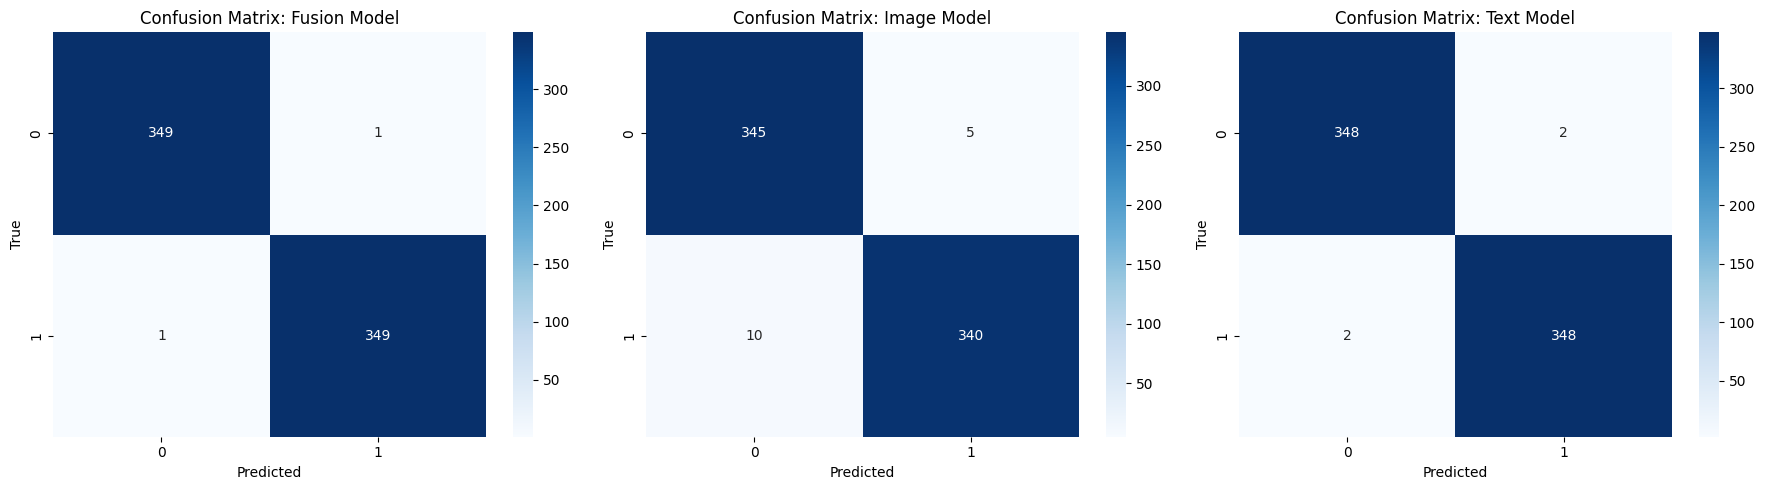


===== MODEL COMPARISON =====
   Metric  Fusion Model  Image Model  Text Model
 Accuracy        0.9971       0.9786      0.9943
Precision        0.9971       0.9855      0.9943
   Recall        0.9971       0.9714      0.9943
 F1 Score        0.9971       0.9784      0.9943


In [38]:
# Display the Confusion Matrix
plot_confusion_matrices(conf_matrices)

# Display the comparison table with 4 decimal places
print("\n===== MODEL COMPARISON =====")
print(comparison_df.round(4).to_string(index=False))

In [39]:
def evaluate_and_show_errors(fusion_model, data_loader, device, num_samples_to_show=10):
    fusion_model.eval()
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    def unnormalize(tensor, mean, std):
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return tensor

    error_samples = []  # Simpan (image, text, label, image_pred, text_pred, fusion_pred)

    with torch.no_grad():
        for batch_data in tqdm(data_loader, desc="Evaluating Fusion Model"):
            images = batch_data['image'].to(device)
            input_ids = batch_data['input_ids'].to(device)
            attention_mask = batch_data['attention_mask'].to(device)
            labels = batch_data['label'].to(device)

            fused_logits, image_logits, text_logits, _ = fusion_model(images, input_ids, attention_mask)
            
            fused_probs = torch.sigmoid(fused_logits)
            image_probs = torch.sigmoid(image_logits)
            text_probs = torch.sigmoid(text_logits)
            
            fused_preds = (fused_probs > 0.5).long()
            image_preds = (image_probs > 0.5).long()
            text_preds = (text_probs > 0.5).long()
            
            # Loop tiap sample
            for i in range(images.size(0)):
                label = labels[i].item()
                fusion_pred = fused_preds[i].item()
                image_pred = image_preds[i].item()
                text_pred = text_preds[i].item()

                # if fusion_pred == label and (image_pred != label or text_pred != label):
                if fusion_pred == label and image_pred == label and text_pred != label:
                    error_samples.append({
                        "image": images[i].cpu(),
                        "input_ids": input_ids[i].cpu(),
                        "label": label,
                        "image_pred": image_pred,
                        "text_pred": text_pred,
                        "fusion_pred": fusion_pred
                    })

    print(f"\n[INFO] Menemukan {len(error_samples)} prediksi 'fusion benar, image/text salah'")
    samples_to_show = error_samples[:num_samples_to_show]

    for idx, sample in enumerate(samples_to_show):
        # Unnormalize sebelum ditampilkan
        image_tensor = sample["image"].clone()
        image_tensor = unnormalize(image_tensor, mean, std)
        image_np = image_tensor.permute(1, 2, 0).numpy().clip(0, 1)

        text_decoded = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)

        plt.figure(figsize=(4, 4))
        plt.imshow(image_np)
        plt.axis('off')
        plt.title(f"Sample #{idx+1}")
        plt.show()
        
        print(f"[TEXT]: {text_decoded}")
        print(f"[LABEL]: {sample['label']}")
        print(f"[PRED - Image]: {sample['image_pred']}, [PRED - Text]: {sample['text_pred']}, [PRED - Fusion]: {sample['fusion_pred']}")
        print("-" * 60)


Evaluating Fusion Model: 100%|██████████| 44/44 [00:13<00:00,  3.24it/s]


[INFO] Menemukan 3 prediksi 'fusion benar, image/text salah'


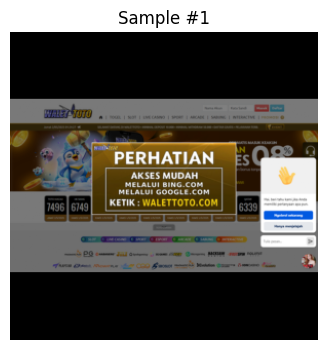

[TEXT]: akses mudah melalui bing com melalui google com ketik walettoto com
[LABEL]: 1
[PRED - Image]: 1, [PRED - Text]: 0, [PRED - Fusion]: 1
------------------------------------------------------------


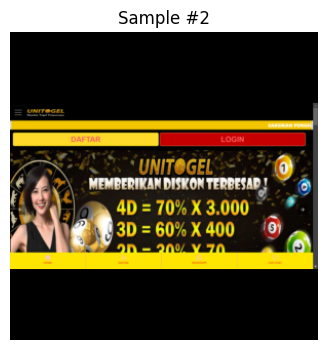

[TEXT]: unit gel login diskon tes ke
[LABEL]: 1
[PRED - Image]: 1, [PRED - Text]: 0, [PRED - Fusion]: 1
------------------------------------------------------------


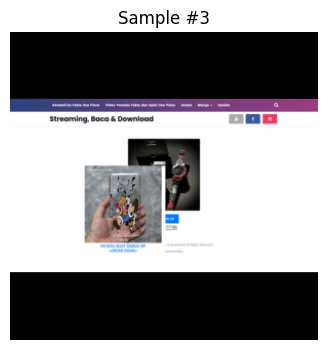

[TEXT]: ini bisa buat semua download all right reserved disini
[LABEL]: 0
[PRED - Image]: 0, [PRED - Text]: 1, [PRED - Fusion]: 0
------------------------------------------------------------


In [40]:
evaluate_and_show_errors(fusion_model, combined_test_loader, device)